In [293]:
import codecs
from collections import defaultdict
import os
import pickle
from operator import add
from functools import reduce
import itertools

import matplotlib.pyplot as plt
import numpy as np
import sklearn.manifold as manifold
import sklearn.cluster as cluster
import torch
from tqdm import tqdm
import transformers

In [223]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

mbart_model = "facebook/mbart-large-50-many-to-many-mmt"

model = MBartForConditionalGeneration.from_pretrained(mbart_model)
tokenizer = MBart50TokenizerFast.from_pretrained(mbart_model, src_lang="de_DE", tgt_lang="en_XX")

In [224]:
# Read in data
DATA_DIR = "./data/wmt19/ende"

In [225]:
references = defaultdict(list)

for ref_path in os.listdir(DATA_DIR):
    with codecs.open(os.path.join(DATA_DIR, ref_path), "rb", "utf-8") as ref_file:
        for i, line in enumerate(ref_file.readlines()):
            references[i].append(line.strip())

In [77]:
references

defaultdict(list,
            {0: ['Abgeordnete walisischen Ursprungs machen sich Sorgen, „wie Idioten auszusehen“',
              'Walisische Abgeordnete befürchten als ,Idioten’ dazustehen.',
              'Walisische Abgeordnete befürchten als ,Idioten’ dazustehen.',
              'Abgeordnete aus Wales hatten Angst, das Bild von „Dummköpfen“ abzugeben.',
              'Walisische Abgeordnete befürchten als ,Idioten’ dazustehen.',
              'Abgeordnete walisischen Ursprungs machen sich Sorgen, „wie Idioten auszusehen“'],
             1: ['Der Vorschlag, den Namen der Versammlung in MWP (Mitglied des walisischen Parlaments) zu ändern, rief bei einigen ihrer Angehörigen Fassungslosigkeit hervor.',
              'Bei einigen AMs herrscht Fassungslosigkeit über einen Vorschlag, ihr Titel solle in MWPs (Members of the Welsh Parliament) geändert werden.',
              'Bei einigen AMs herrscht Fassungslosigkeit über einen Vorschlag, ihr Titel solle in MWPs (Members of the Welsh Parl

In [213]:
def extract_latents(model, tokenizer, sentences):
    # Tokenize inputs and feed to model
    generation_config = transformers.GenerationConfig.from_pretrained(mbart_model)
    generation_config.decoder_hidden_states = True
    generation_config.return_dict_in_generate = True
    generation_config.num_beams = 1  # TODO: Debug
    #print(generation_config)
    
    tokenized_sequences = tokenizer(sentences, return_tensors="pt", padding=True)
    in_shape = tokenized_sequences["input_ids"].shape[0]
    
    outputs = model.generate(
        input_ids=tokenized_sequences["input_ids"], 
        attention_mask=tokenized_sequences["attention_mask"],
        output_hidden_states=True,
        forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"],
        generation_config=generation_config,
        return_dict_in_generate=True,
    )
    #print("Generated shape", outputs.sequences.shape)

    #decoded = tokenizer.batch_decode(outputs.sequences)
    #print(outputs.keys
    
    # Collect special tokens
    ignore_token_ids = (
        set(tokenizer.lang_code_to_id.values())
        | set (tokenizer.prefix_tokens)
        | set (tokenizer.suffix_tokens)
    )
    ignore_token_ids |= {
        tokenizer.bos_token_id, tokenizer.eos_token_id, tokenizer.sep_token_id, tokenizer.pad_token_id
    }
    
    # outputs.decoder_hidden_states has the following structure:
    # One tuple entry per time step
    # Inside that: 13 entries for every decoder layer
    # Inside the uppermost decoder layer: Shape [30, 1, 1024]
    # 30: batch size (?), 1: sequence length, 1024: Embedding size
    # batch size here is actual batch size x beam size
    
    decoder_states = outputs.decoder_hidden_states
    
    reference_encodings = defaultdict(list)
    
    for t in range(len(decoder_states)):
        hidden = decoder_states[t][-1]
        
        for b in range(hidden.shape[0]):
            token_id = outputs.sequences[b][t]
            
            if token_id in ignore_token_ids:
                continue
                
            encoding = hidden[b]
                
            reference_encodings[b].append(encoding)
    
    
    return reference_encodings

In [227]:
ENCODING_PATH = "ref_encodings10.pickle"

if not os.path.exists(ENCODING_PATH):
    reference_encodings = {}

    for i in tqdm(references.keys()):

        if i > 10:
            break

        reference_encodings[i] = extract_latents(model, tokenizer, references[i])
    
    with open(ENCODING_PATH, "wb") as encoding_file:
        pickle.dump(reference_encodings, encoding_file)
        
else:
    with open(ENCODING_PATH, "rb") as encoding_file:
        reference_encodings = pickle.load(encoding_file)

  0%|                                                                                                                                                                                                           | 0/1997 [00:00<?, ?it/s]/Users/deul/anaconda3/envs/nlg-conformal-risk-control/lib/python3.8/site-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 200 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
  1%|█                                                                                                                                                                                               | 11/1997 [02:10<6:34:11, 11.91s/it]


In [239]:
def fit_projection(reference_encodings):
    # Fit dimensionality reductions 
    X = []
    
    for ref_encodings in reference_encodings.values():
        for encodings in ref_encodings.values():
            X += encodings
            
    # Flatten list
    X = torch.concatenate(X, dim=0).numpy()
    
    # Fit transformation
    tsne = manifold.TSNE()
    tsne.fit(X)
    
    return tsne

In [240]:
tsne = fit_projection(reference_encodings)

In [303]:
def plot_encodings(reference_encodings, projection, cluster_assignments=None):
    
    total_i = 0
    
    if cluster_assignments is not None:
        markers = itertools.cycle(matplotlib.markers.MarkerStyle.markers.keys()) 
        cluster2marker = {
            cluster: next(markers)
            for cluster in range(-1, max(cluster_assignments) + 1)
        }
    
    
    with tqdm(total=len(reference_encodings) * len(reference_encodings[0])) as pbar:
        for sentence_idx, encodings in reference_encodings.items():
            color = np.random.rand(3) 
            color /= color.sum() * 0.8
            
            for ref_idx, encs in encodings.items():

                for i, enc in enumerate(encs):
                    alpha_discount = i / len(encs)

                    projected_enc = projection.embedding_[total_i]
                    enc_x, enc_y = tuple(projected_enc)
                    
                    marker = None
                    if cluster_assignments is not None:
                        marker = cluster2marker[cluster_assignments[total_i]]
                        

                    plt.scatter(enc_x, enc_y, alpha=1 - alpha_discount, color=color, marker=marker)

                    total_i += 1
                
                pbar.update(1)
                
    plt.tight_layout()
    plt.show()
        

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:10<00:00,  6.55it/s]


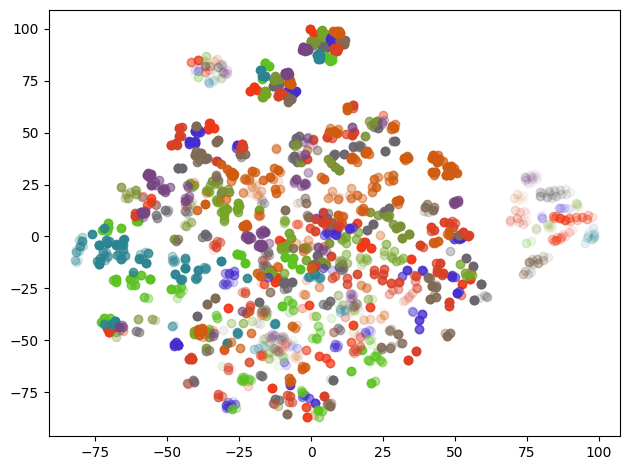

In [276]:
plot_encodings(reference_encodings, tsne)

In [305]:
def cluster_latents(reference_encodings, min_samples = 6):
    # Fit clustering
    X = []
    
    for ref_encodings in reference_encodings.values():
        for encodings in ref_encodings.values():
            X += encodings
            
    # Flatten list
    X = torch.concatenate(X, dim=0).numpy()
    clustering = cluster.OPTICS(min_samples=min_samples).fit(X)
    labels = clustering.labels_
    
    return labels

In [306]:
labels = cluster_latents(reference_encodings)

In [307]:
print(labels)

[ -1  -1  85 ...  -1 122 122]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 66/66 [00:09<00:00,  6.96it/s]


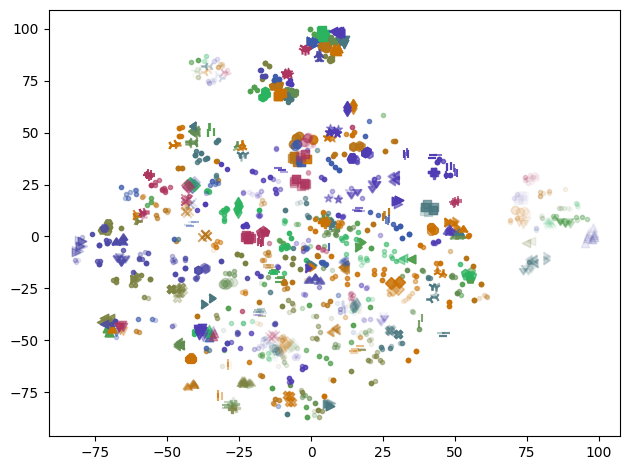

In [308]:
plot_encodings(reference_encodings, tsne, labels)